In [9]:
import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from astropy import units as u 
from astropy.table import Table

from snewpy.neutrino import Flavor, MassHierarchy, MixingParameters
from snewpy.models import Nakazato_2013
from snewpy.models.ccsn import Fornax_2022
from snewpy.models.ccsn import Bollig_2016
from snewpy.models.ccsn import Sukhbold_2015
from snewpy.flavor_transformation import AdiabaticMSW, NonAdiabaticMSWH, \
                                         TwoFlavorDecoherence, ThreeFlavorDecoherence, \
                                         NeutrinoDecay, AdiabaticMSWes, NonAdiabaticMSWes
from asteria import set_rcparams
from asteria.simulation import Simulation

%matplotlib inline

C:\Users\sanya\AppData\Local\Temp\ipykernel_25352\3227033813.py:11: FutureWarning: snewpy.models.Nakazato_2013 is moved to snewpy.models.ccsn.Nakazato_2013
  from snewpy.models import Nakazato_2013


In [10]:
import numpy as np
from scipy.special import logsumexp, betaln, gammaln
from scipy.stats import norm
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd


def pt_d_sample_test(data1, data2, c=1, max_depth=-1, qdist=norm.ppf, aj=lambda depth: depth**2, log_BF=False):
    old_expressions = np.get_printoptions()['threshold']
    np.set_printoptions(threshold=max(max_depth, old_expressions))

    if max_depth < 0:
        max_depth = max(1, int(np.floor(np.log2(len(data1)) / 2)))

    # Combine datasets and create a group identifier
    binary = np.concatenate((np.zeros(len(data1)), np.ones(len(data2))))
    continuous = np.concatenate((data1, data2))
    data = np.column_stack([scale(continuous), binary])
    X = data[:, 0]  # assign the scaled value to X

    p_H0 = pt_marginal_likelihood(X, low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj)

    discrete_values = np.unique(binary)

    p_H1 = max([pt_marginal_likelihood(data[data[:, 1] == i, 0], low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj) +
                pt_marginal_likelihood(data[data[:, 1] != i, 0], low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj)
                for i in discrete_values])

    n_hypotheses = len(discrete_values)
    logbf = p_H0 - p_H1 + np.log(n_hypotheses)
    np.set_printoptions(threshold=old_expressions)

    if log_BF:
        return logbf
    else:
        bf = np.exp(logbf)
        return bf


def pt_marginal_likelihood(data, low, up, c, depth, max_depth, qdist, aj):
    if depth == max_depth:
        return 0

    if isinstance(low, (int, float)):  # if low is an integer
        n_j = [
            np.sum((qdist(low) < data) & (data <= qdist((low + up) / 2))),
            np.sum((qdist((low + up) / 2) < data) & (data <= qdist(up)))
        ]  # counts the number of data in each interval (2 vector).
    else:
        n_j = [
            np.sum((qdist(low[0]) < data[:, 0]) & (data[:, 0] <= qdist((low[0] + up[0]) / 2)) &
                   (qdist(low[1]) < data[:, 1]) & (data[:, 1] <= qdist((low[1] + up[1]) / 2))),
            np.sum((qdist((low[0] + up[0]) / 2) < data[:, 0]) & (data[:, 0] <= qdist(up[0])) &
                   (qdist(low[1]) < data[:, 1]) & (data[:, 1] <= qdist((low[1] + up[1]) / 2))),
            np.sum((qdist(low[0]) < data[:, 0]) & (data[:, 0] <= qdist((low[0] + up[0]) / 2)) &
                   (qdist((low[1] + up[1]) / 2) < data[:, 1]) & (data[:, 1] <= qdist(up[1]))),
            np.sum((qdist((low[0] + up[0]) / 2) < data[:, 0]) & (data[:, 0] <= qdist(up[0])) &
                   (qdist((low[1] + up[1]) / 2) < data[:, 1]) & (data[:, 1] <= qdist(up[1])))
        ]  # 4 vector 

    if np.sum(n_j) == 0:
        return 0

    a_j = c * aj(depth)

    if len(n_j) == 2:
        logl = betaln(n_j[0] + a_j, n_j[1] + a_j) - betaln(a_j, a_j)  # log of beta function
    else:
        logl = lmbeta(n_j[0] + a_j, n_j[1] + a_j, n_j[2] + a_j, n_j[3] + a_j) - lmbeta(a_j, a_j, a_j, a_j)

    if isinstance(low, (int, float)):
        likelihoods = [
            pt_marginal_likelihood(data, low, (low + up) / 2, c, depth + 1, max_depth, qdist, aj),
            pt_marginal_likelihood(data, (low + up) / 2, up, c, depth + 1, max_depth, qdist, aj)
        ]  # likelihood of subpartitions
    else:
        likelihoods = [
            pt_marginal_likelihood(data, low, (low + up) / 2, c, depth + 1, max_depth, qdist, aj),
            pt_marginal_likelihood(data, (low + up) / 2, up, c, depth + 1, max_depth, qdist, aj),
            pt_marginal_likelihood(data, [low[0], (low[1] + up[1]) / 2], [(low[0] + up[0]) / 2, up[1]],
                                   c, depth + 1, max_depth, qdist, aj),
            pt_marginal_likelihood(data, [(low[0] + up[0]) / 2, low[1]], [up[0], (low[1] + up[1]) / 2],
                                   c, depth + 1, max_depth, qdist, aj)
        ]

    return logl + np.sum(likelihoods)


def lmbeta(*args):
    return np.sum(gammaln(args)) - gammaln(np.sum(args))


def is_discrete(X):
    return np.all(np.isin(X, np.arange(11)))  # evaluates to TRUE only if every element of X lies within the specified range of 0 to 10.


def scale(data):
    return (data - np.mean(data)) / np.std(data)


**MODEL DEPENDENT**

In [3]:
sukh_param=list(params for params in Sukhbold_2015.get_param_combinations() if params['progenitor_mass'].value == 27 
                      and params['eos']=='LS220')

In [8]:
help(Simulation)

Help on class Simulation in module asteria.simulation:

class Simulation(builtins.object)
 |  Simulation(config=None, *, model=None, distance=<Quantity 10. kpc>, res_dt=<Quantity 2. ms>, flavors=None, hierarchy=None, interactions=<enum 'Interactions'>, mixing_scheme=None, mixing_angle=None, E=None, Emin=None, Emax=None, dE=None, t=None, tmin=None, tmax=None, dt=None, geomfile=None, effvolfile=None)
 |  
 |  Top-level class for performing ASTERIA's core simulation routine, and handler for the resulting outputs
 |  
 |  Methods defined here:
 |  
 |  __init__(self, config=None, *, model=None, distance=<Quantity 10. kpc>, res_dt=<Quantity 2. ms>, flavors=None, hierarchy=None, interactions=<enum 'Interactions'>, mixing_scheme=None, mixing_angle=None, E=None, Emin=None, Emax=None, dE=None, t=None, tmin=None, tmax=None, dt=None, geomfile=None, effvolfile=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  avg_dom_signal(self, dt=None, flavor=None)
 |      Re

In [4]:
forn_param=list(params for params in Fornax_2022.get_param_combinations() if params['progenitor_mass'].value == 12.54 
                      )

In [5]:
forn_param

[{'progenitor_mass': <Quantity 12.54 solMass>}]

In [6]:
model_a = {'name': 'Sukhbold_2015',
            'param': sukh_param[0]
              }

In [7]:
labels=['nmo','imo']
norms=[]
nmos=[]
imos=[]
sims1=[nmos,imos]
for i in range(654,1001):
    sim_i = Simulation(model=model_a,
                     distance=10 * u.kpc, 
                     Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                     tmin=-10*u.s,  tmax=10*u.s,    dt=1*u.ms,
                     mixing_scheme='AdiabaticMSW',
                     hierarchy='inverted')


    sim_n = Simulation(model=model_a,
                     distance=10 * u.kpc, 
                     Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                     tmin=-10*u.s,tmax=10*u.s, dt=1*u.ms,
                     mixing_scheme='AdiabaticMSW',
                     hierarchy='normal')
    sim_i.run()
    sim_n.run()
    for j,simm in enumerate([sim_n,sim_i]): 
        with open("Sukhbold_eos={}_M={}_mix={}_num={}.pkl".format(sukh_param[0]['eos'],
                                                                  sukh_param[0]['progenitor_mass'].value, 
                                                                 labels[j], i), 'wb') as f:
            pickle.dump(simm, f)
        sims1[j].append(simm)

C:\Users\sanya\miniconda3\lib\site-packages\snewpy\models\base.py:302: RuntimeWarning: divide by zero encountered in log
  np.exp(np.log(L) - (2+a)*np.log(Ea) + (1+a)*np.log(1+a)
C:\Users\sanya\miniconda3\lib\site-packages\snewpy\models\base.py:302: RuntimeWarning: invalid value encountered in subtract
  np.exp(np.log(L) - (2+a)*np.log(Ea) + (1+a)*np.log(1+a)
C:\Users\sanya\miniconda3\lib\site-packages\snewpy\models\base.py:303: RuntimeWarning: divide by zero encountered in divide
  - loggamma(1+a) + a*np.log(E) - (1+a)*(E/Ea)) / (u.erg * u.s)


In [11]:
labels=['nmo','imo']
nmos=[]
imos=[]
sims1=[nmos,imos]

for i in range(100):
    for j,lab in enumerate(labels): 
        with open("Sukhbold_eos={}_M={}_mix={}_num={}.pkl".format(sukh_param[0]['eos'], 
                                                                 sukh_param[0]['progenitor_mass'].value,
                                                                 labels[j], i), 'rb') as f:
            mod=pickle.load(f)
        sims1[j].append(mod)

In [95]:
np.where(t==-5*u.s)[0][0]

2500

Text(0.5, 1.0, 'Detector Signal for 100 Simulations, Sukhbold with M=27 and EOS=LS220, d=10kpc')

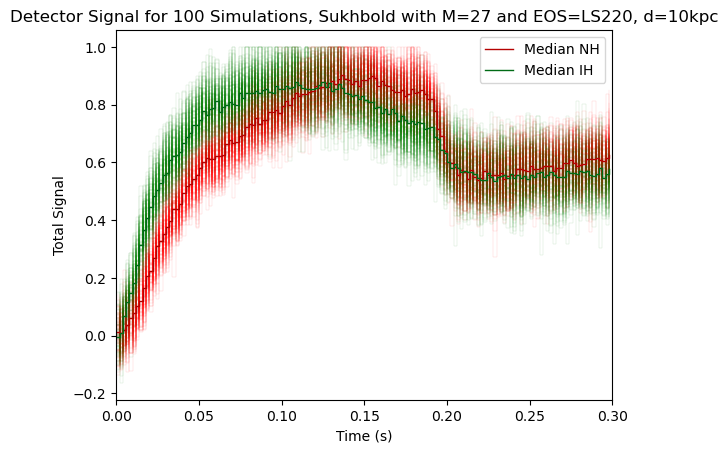

In [16]:
dt = 2 * u.ms
colors=['blue','red','green','orange']
labels=['Normal','NH','IH']

hits_nh=[]
hits_ih=[]
hits_tot=[hits_nh,hits_ih]

for i in range(100):
    for j in range(0,2):
        simm=sims1[j][i]
        simm.rebin_result(dt)
        simm.scale_result(10*u.kpc)
        t, hits = simm.detector_signal(dt)
        bg = simm.detector.i3_bg(dt, size=hits.size) + simm.detector.dc_bg(dt, size=hits.size)
        sig=bg+hits
        id1=np.where(t==-5*u.s)[0][0]
        id2=np.where(t==-.5*u.s)[0][0]
        id3=np.where(t==5*u.s)[0][0]
        id4=np.where(t==10*u.s)[0][0]
        id5=np.where(t==0*u.s)[0][0]
        id6=np.where(t==.3*u.s)[0][0]
        mean_under=np.mean(np.append(sig[id1:id2],sig[id3:id4]))
        data=np.subtract(sig,mean_under)[id5:id6]
        
        
        m=np.max(data)
        norm_data=data/m
        
        hits_tot[j].append(norm_data)
        
        plt.step(t[id5:id6], norm_data, where='post',lw=.2,color=colors[j+1],alpha=.3)

med_nh=np.median(hits_tot[0],axis=0)
med_ih=np.median(hits_tot[1],axis=0)
plt.step(t[id5:id6],med_nh,where='post',lw=1,color='#b50202',label='Median NH')
plt.step(t[id5:id6],med_ih,where='post',lw=1,color='#016b16',label='Median IH')

plt.legend()
plt.xlim(0,.3)
plt.xlabel('Time (s)')
plt.ylabel('Total Signal')
plt.title('Detector Signal for 100 Simulations, Sukhbold with M=27 and EOS=LS220, d=10kpc')

**BAYES FACTOR**

In [87]:
t[5500]

<Quantity 1. s>

In [23]:
bfs_norm=[]
dt = 2*u.ms

for i in range(100):
    for j in range(100):
        simm_nh=sims1[0][i]
        simm_nh.rebin_result(dt)
        simm.scale_result(20*u.kpc)
        
        data1=hits_tot[0][i]
        
        m=np.max(data1)
        norm_data1=data1/m
        
        
        data2=hits_tot[1][i]
        m=np.max(data2)
        norm_data2=data2/m
        
        log_bf = pt_d_sample_test(data1, data2, log_BF=True)
        bfs_norm.append(log_bf)
        

Text(0.5, 1.0, 'Bayes Factors for 10000 Combinations of Normalized NH and IH for d=10kpc')

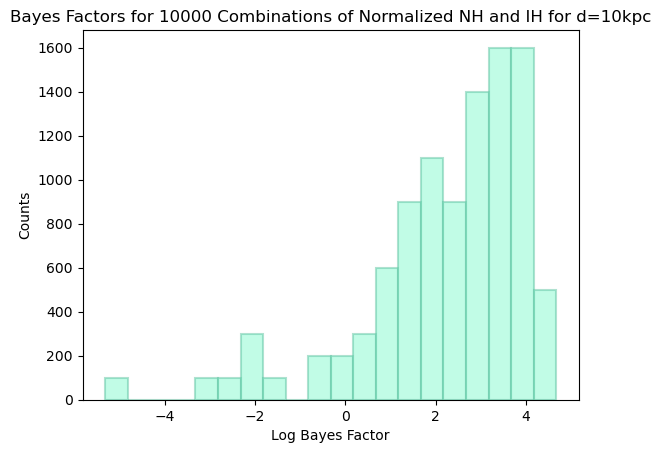

In [24]:
plt.hist(bfs_norm, alpha=0.5, color='#84facf', edgecolor='#60c4a3', linewidth=1.5,bins=20)
plt.xlabel('Log Bayes Factor')
plt.ylabel('Counts')
plt.title('Bayes Factors for 10000 Combinations of Normalized NH and IH for d=10kpc')

**KS TEST**

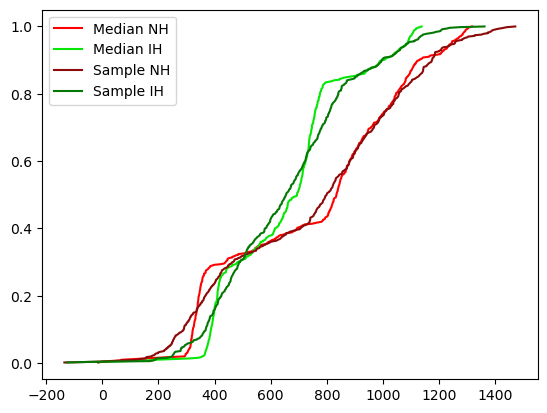

In [6]:
dt = 2 * u.ms
colors=['blue','red','green','orange']
labels=['Normal','NH','IH']

hits_nh=[]
hits_ih=[]
hits_tot=[hits_nh,hits_ih]

for i in range(100):
    for j in range(0,2):
        simm=sims1[j][i]
        simm.rebin_result(dt)
        t, hits = simm.detector_signal(dt)
        bg = simm.detector.i3_bg(dt, size=hits.size) + simm.detector.dc_bg(dt, size=hits.size)
        sig=hits+bg
        id1=np.where(t==-5*u.s)[0][0]
        id2=np.where(t==-.5*u.s)[0][0]
        id3=np.where(t==5*u.s)[0][0]
        id4=np.where(t==10*u.s)[0][0]
        id5=np.where(t==0*u.s)[0][0]
        id6=np.where(t==1*u.s)[0][0]
        mean_under=np.mean(np.append(sig[id1:id2],sig[id3:id4]))
        data=np.subtract(sig,mean_under)[id5:id6]
        hits_tot[j].append(data)
        
med_nh=np.median(hits_tot[0],axis=0)
med_ih=np.median(hits_tot[1],axis=0)

cdf_med_nh=np.sort(med_nh)
cdf_med_ih=np.sort(med_ih)

plt.plot(cdf_med_nh, np.arange(1, len(cdf_med_nh) + 1) / len(cdf_med_nh), color='red',label='Median NH')
plt.plot(cdf_med_ih, np.arange(1, len(cdf_med_ih) + 1) / len(cdf_med_ih), color='#05e605',label='Median IH')

plt.plot(np.sort(hits_tot[0][0]), np.arange(1, len(hits_tot[0][0]) + 1) / len(hits_tot[0][0]), 
         color='#8c0a0a',label='Sample NH')
plt.plot(np.sort(hits_tot[1][0]), np.arange(1, len(hits_tot[1][0]) + 1) / len(hits_tot[1][0]), 
         color='#047804',label='Sample IH')

plt.legend()


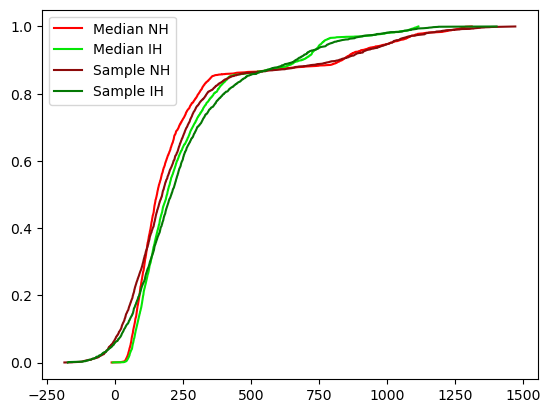

In [7]:
dt = 2 * u.ms
colors=['blue','red','green','orange']
labels=['Normal','NH','IH']

hits_nh=[]
hits_ih=[]
hits_tot=[hits_nh,hits_ih]

for i in range(100):
    for j in range(0,2):
        simm=sims1[j][i]
        simm.rebin_result(dt)
        t, hits = simm.detector_signal(dt)
        bg = simm.detector.i3_bg(dt, size=hits.size) + simm.detector.dc_bg(dt, size=hits.size)
        sig=hits+bg
        id1=np.where(t==-5*u.s)[0][0]
        id2=np.where(t==-.5*u.s)[0][0]
        id3=np.where(t==5*u.s)[0][0]
        id4=np.where(t==10*u.s)[0][0]
        id5=np.where(t==0*u.s)[0][0]
        id6=np.where(t==5*u.s)[0][0]
        mean_under=np.mean(np.append(sig[id1:id2],sig[id3:id4]))
        data=np.subtract(sig,mean_under)[id5:id6]
        hits_tot[j].append(data)
        
med_nh=np.median(hits_tot[0],axis=0)
med_ih=np.median(hits_tot[1],axis=0)

cdf_med_nh=np.sort(med_nh)
cdf_med_ih=np.sort(med_ih)

plt.plot(cdf_med_nh, np.arange(1, len(cdf_med_nh) + 1) / len(cdf_med_nh), color='red',label='Median NH')
plt.plot(cdf_med_ih, np.arange(1, len(cdf_med_ih) + 1) / len(cdf_med_ih), color='#05e605',label='Median IH')

plt.plot(np.sort(hits_tot[0][0]), np.arange(1, len(hits_tot[0][0]) + 1) / len(hits_tot[0][0]), 
         color='#8c0a0a',label='Sample NH')
plt.plot(np.sort(hits_tot[1][0]), np.arange(1, len(hits_tot[1][0]) + 1) / len(hits_tot[1][0]), 
         color='#047804',label='Sample IH')

plt.legend()


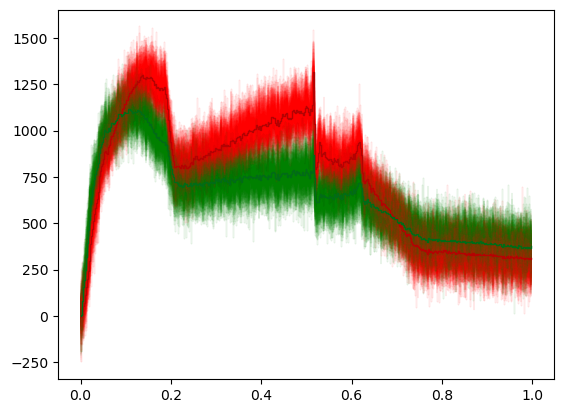

In [19]:
for i in range(100,200):
    for j in range(0,2):
        dat=hits_tot[j][i]
        plt.step(t[id5:id6], dat, where='post',lw=.2,color=colors[j+1],alpha=.3)

plt.step(t[id5:id6],med_nh,where='post',lw=1,color='#b50202',label='Median NH')
plt.step(t[id5:id6],med_ih,where='post',lw=1,color='#016b16',label='Median IH')

In [69]:
ks_nh=[]
cdfs_nh=[]
pval_nh=[]

for i in range(100):
    sorted_sig=np.sort(hits_tot[0][i])
    cdfs_nh.append(sorted_sig)
    statistic, p_value = stats.ks_2samp(sorted_sig, cdfs_nh[0], alternative='two-sided', mode='auto')
    pval_nh.append(p_value)
    ks_nh.append(statistic)

In [70]:
ks_ih=[]
cdfs_ih=[]
pval_ih=[]

for i in range(100):
    sorted_sig=np.sort(hits_tot[1][i])
    cdfs_ih.append(sorted_sig)
    statistic, p_value = stats.ks_2samp(sorted_sig, cdfs_nh[0], alternative='two-sided', mode='auto')
    pval_ih.append(p_value)
    ks_ih.append(statistic)

In [28]:
ks_nh_med=[]
cdfs_nh_med=[]
pval_nh_med=[]

for i in range(1001):
    sorted_sig=np.sort(hits_tot[0][i])
    cdfs_nh_med.append(sorted_sig)
    statistic, p_value = stats.ks_2samp(sorted_sig, cdf_med_nh, alternative='two-sided', mode='auto')
    pval_nh_med.append(p_value)
    ks_nh_med.append(statistic)

In [29]:
ks_ih_med=[]
cdfs_ih_med=[]
pval_ih_med=[]

for i in range(1001):
    sorted_sig=np.sort(hits_tot[1][i])
    cdfs_ih_med.append(sorted_sig)
    statistic, p_value = stats.ks_2samp(sorted_sig, cdf_med_nh, alternative='two-sided', mode='auto')
    pval_ih_med.append(p_value)
    ks_ih_med.append(statistic)

In [80]:
ks_ih_medih=[]
cdfs_ih_medih=[]
pval_ih_medih=[]

for i in range(100):
    sorted_sig=np.sort(hits_tot[1][i])
    cdfs_ih_medih.append(sorted_sig)
    statistic, p_value = stats.ks_2samp(sorted_sig, cdf_med_ih, alternative='two-sided', mode='auto')
    pval_ih_medih.append(p_value)
    ks_ih_medih.append(statistic)

Text(0.5, 1.0, 'KS Distances for NH and IH, from t=0 to t=1')

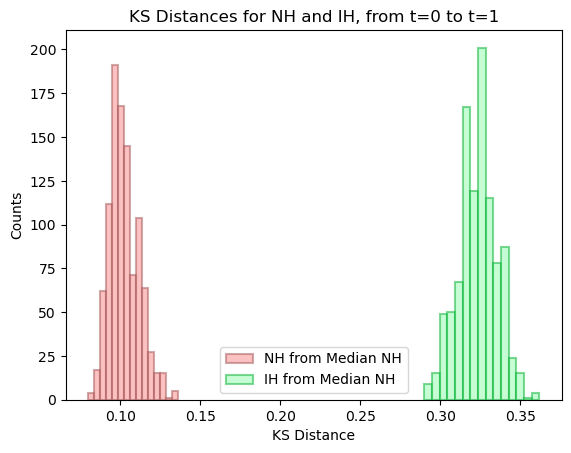

In [30]:
plt.hist(ks_nh_med, alpha=0.5, color='#fa8787', edgecolor='#a35656', linewidth=1.5,label='NH from Median NH',bins=15)
plt.hist(ks_ih_med, alpha=0.5, color='#90fcad', edgecolor='#02b031', linewidth=1.5,label='IH from Median NH',bins=15)
#plt.hist(ks_ih_medih, alpha=0.5, color='#51fafc', edgecolor='#3fc3c4', linewidth=1.5,label='IH from Median IH',bins=15)

plt.legend()
#plt.xlim(0,.2)
plt.xlabel('KS Distance')
plt.ylabel('Counts')
plt.title('KS Distances for NH and IH, from t=0 to t=1')

In [133]:
def compute_ks_pval(area_tot,ks_dist,statistic):
    dist_above=ks_dist[ks_dist>=statistic]
    if len(dist_above)==0:
        return 1/area_tot
    else:
        return len(dist_above)/area_tot

In [141]:
np.sort(ks_ih_med)[1]

0.13346153846153846

In [150]:
np.sort(ks_nh_med)[-1]

0.13423076923076924

In [151]:
ks_nh_med=np.array(ks_nh_med)
ks_nh_med[ks_nh_med>=np.sort(ks_ih_med)[1]]

array([0.13346154, 0.13423077, 0.13346154])

(array([98.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([0.01 , 0.012, 0.014, 0.016, 0.018, 0.02 , 0.022, 0.024, 0.026,
        0.028, 0.03 ]),
 <BarContainer object of 10 artists>)

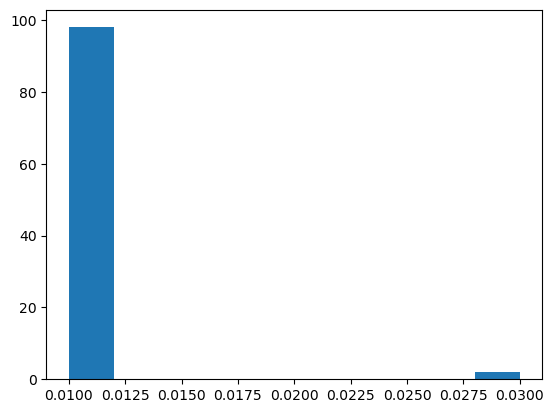

In [139]:
p_vals=[]
for i,stat in enumerate(ks_ih_med):
    p_vals.append(compute_ks_pval(100,np.array(ks_nh_med),stat))
    
plt.hist(p_vals,bins=10,range=(.01,.03), alpha=0.5, color='#90fcad', edgecolor='#02b031', linewidth=1.5,)
plt.title('P values for KS tests of IH vs Median NH')
plt.xlabel('p value')
plt.ylabel('counts')

Text(0.5, 1.0, 'KS Distances for NH and IH Compared to Random NH')

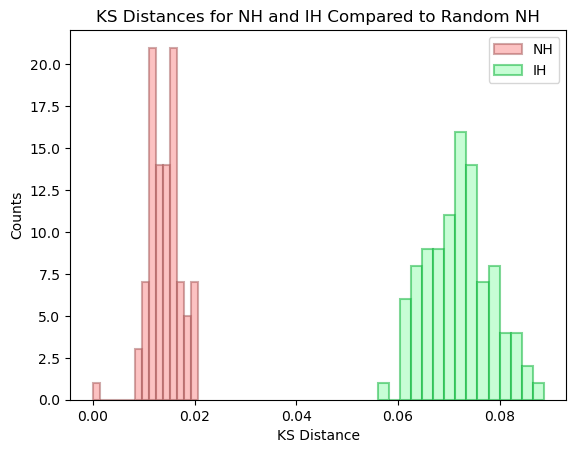

In [75]:
plt.hist(ks_nh, alpha=0.5, color='#fa8787', edgecolor='#a35656', linewidth=1.5,label='NH',bins=15)
plt.hist(ks_ih, alpha=0.5, color='#90fcad', edgecolor='#02b031', linewidth=1.5,label='IH',bins=15)
plt.legend()
plt.xlabel('KS Distance')
plt.ylabel('Counts')
plt.title('KS Distances for NH and IH Compared to Random NH')

**MODEL INDEPENDENT, MASS DEPENDENT**

In [ ]:
pred_sukh_param=list(params for params in Sukhbold_2015.get_param_combinations() if params['progenitor_mass'].value == 27 
                      and params['eos']=='SFHo')
pred_forn_param=list(params for params in Fornax_2022.get_param_combinations() if params['progenitor_mass'].value == 26.99)